# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment to find a $\pi$-pulse amplitude on a model of the Armonk one qubit backend, generated from the `FakeArmonk` mock backend.


## 1. Imports

Import general libraries:

In [1]:
import numpy as np

Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:

In [2]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation, as well as the mock Armonk backend:

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

## 2. Construct model from backend

This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** Hamiltonian parameters reported in the backends change over time. To stabilize this tutorial relative to these changes, after instantiating `FakeArmonk`, we manually override the Hamiltonian reported in the backend configuration to static values. 

Instantiate mock backend:

In [4]:
armonk_backend = FakeArmonk()

Manually override Hamiltonian parameters:

In [5]:
freq_est = 4.97e9
drive_est = 6.35e7
armonk_backend.defaults().qubit_freq_est = [freq_est]
armonk_backend.configuration().hamiltonian['h_str']= ['wq0*0.5*(I0-Z0)', 'omegad0*X0||D0']
armonk_backend.configuration().hamiltonian['vars'] = {'wq0': 2 * np.pi * freq_est, 'omegad0': drive_est}
armonk_backend.configuration().hamiltonian['qub'] = {'0': 2}
armonk_backend.configuration().dt = 2.2222222222222221e-10

Generate model from backend:

In [6]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

## 3. Run Rabi experiments and fit $\pi$-pulse amplitude

Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

First, construct Rabi experiment schedules:

In [7]:
# qubit list
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=qubits, 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels, 
                                       inst_map=armonk_backend.defaults().instruction_schedule_map, 
                                       meas_map=armonk_backend.configuration().meas_map)

Assemble the `qobj` for job submission. When assembling pulse schedules to be used with the pulse simulator, pass the `PulseSimulator` as the backend.

In [8]:
backend_sim = PulseSimulator(system_model=armonk_model)

rabi_qobj = assemble(rabi_schedules, 
                     backend=backend_sim,
                     meas_level=1, 
                     meas_return='avg',
                     shots=512)

Run the simulation:

In [9]:
sim_result = backend_sim.run(rabi_qobj).result()

/tmp/qiskit_release/lib/python3.9/site-packages/qiskit/providers/aer/pulse/controllers/pulse_controller.py:142: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is beign automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '
/tmp/qiskit_release/lib/python3.9/site-packages/qiskit/providers/aer/pulse/system_models/string_model_parser/gen_operator.py:141: DeprecationWarning: Using the `__mul__` operator `A * B` as shorthand for `A.dot(B)` is deprecated as of version 0.17.0 and will be  removed no earlier than 3 months after the release date. As an alternative, use the compose operator `B & A` in place of `A * B` as a replacement.
  return psi * psi.adjoint()
/tmp/qiskit_release/lib/python3.9/site-packages/qiskit/providers/aer/pulse/system_models/string_model_parser/operator_generators.py:154: DeprecationWarning: Using the `__matmul__` operator `A @ B` as 

Generate the Rabi oscillation plot and find the $\pi$-pulse amplitude:

Pi Amp: 0.347697


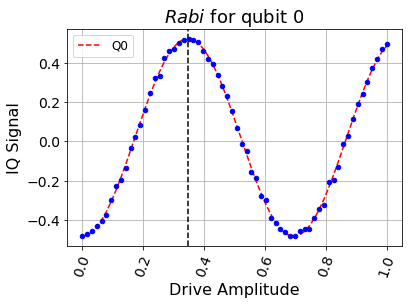

In [10]:
rabi_fit = RabiFitter(sim_result, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_fit.pi_amplitude(0)

# plot
rabi_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/tmp/qiskit_release/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.2
qiskit-aer,0.8.2
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.16.0
qiskit-aqua,0.9.5
qiskit,0.29.1
qiskit-nature,0.2.1
qiskit-finance,0.2.1
qiskit-optimization,0.2.2
qiskit-machine-learning,0.2.1
